# Figure: bibiplots

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pickle
import matplotlib

import sparseRRR

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120     # only affects the notebook

sns_styleset()

In [2]:
def preprocess(data):
    X = data['counts'][:,data['mostVariableGenes']] / np.sum(data['counts'], axis=1) * 1e+6
    X = np.array(X)
    X = np.log2(X + 1)
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['ephys']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return (X,Y)

In [3]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    stop = False
        if stop:
            break

In [9]:
data = pickle.load(open('data/scala2020.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.45, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

data = pickle.load(open('data/scala2019.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.95, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

data = pickle.load(open('data/cadwell2016.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.6, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

data = pickle.load(open('data/gouwens2020.pickle', 'rb'))
X=data['counts'].toarray().astype('float64')
Y=data['ephys']
genes = data['genes']
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.12, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

# Use ephys features to show on plot showing the 10 highest L2 correlation norm with sRRR component 1 and 2 
corr_norm=np.zeros((Y.shape[1],2))
for i in range(Y.shape[1]):
    corr_norm[i,0]=np.corrcoef(Y[:,i],(X@w)[:,0])[0,1]
    corr_norm[i,1]=np.corrcoef(Y[:,i],(X@w)[:,1])[0,1]
gouwens_2020_ephys_features_indices=np.argsort(np.linalg.norm(corr_norm, ord=2,axis=1))[-10:]
gouwens_2020_ephys_features_to_show=data['ephysNames'][gouwens_2020_ephys_features_indices]
print('\nConsistency check of gouwens2020 ephys names: \n')
print('gouwens2020 long ephys names to show: ', gouwens_2020_ephys_features_to_show)
gouwens_2020_ephys_features_to_show_short_names=np.array(['Spc2 AP1 dv', 'Spc1 thresh.', 'Tau', 'R_input', \
                                                          'Short sq. AP1 downstroke', 'Spc0 AP width', \
                                                          'Spc0 AP1 v', 'Rheobase', 'Short sq. AP1 UDR', \
                                                          'Spc0 UDR'])
print('gouwens2020 short ephys names to show: ', gouwens_2020_ephys_features_to_show_short_names)

Genes selected: 20
Genes selected: 20
Genes selected: 20
Genes selected: 20

Consistency check of gouwens2020 ephys names: 

gouwens2020 long ephys names to show:  ['spc2 first AP dv' 'spc1 spk. thr. v' 'tau' 'input resistance'
 'short sq. AP1 downstroke' 'spc0 spk. width' 'spc0 first AP v'
 'rheobase i' 'short sq. AP1 up-down ratio' 'spc0 spk. up-down ratio']
gouwens2020 short ephys names to show:  ['Spc2 AP1 dv' 'Spc1 thresh.' 'Tau' 'R_input' 'Short sq. AP1 downstroke'
 'Spc0 AP width' 'Spc0 AP1 v' 'Rheobase' 'Short sq. AP1 UDR' 'Spc0 UDR']


<IPython.core.display.Javascript object>


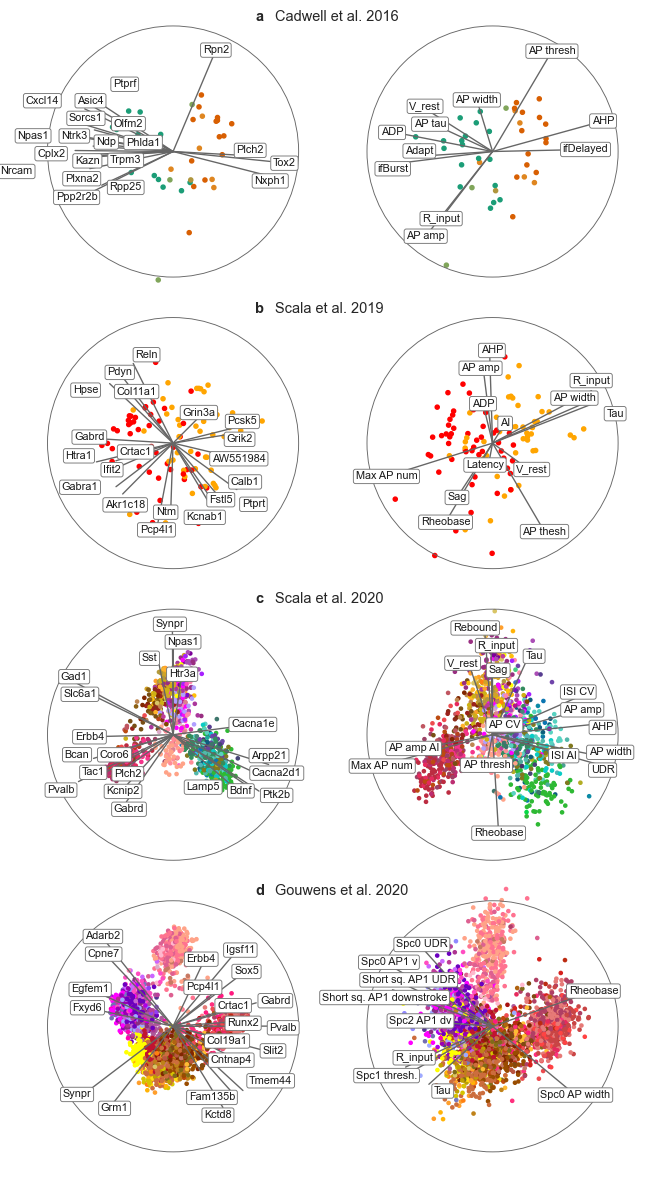

In [37]:
fig = plt.figure(figsize=(5, 9))

titles = ['Cadwell et al. 2016', 'Scala et al. 2019', 'Scala et al. 2020', 'Gouwens et al. 2020']
files = ['cadwell2016.pickle', 'scala2019.pickle', 'scala2020.pickle', 'gouwens2020.pickle']
lambdas = [1.6, .95, .45, 1.12]
alphas = [.5, .5, 1, 1]
sizes = [5, 5, 3, 3]
scaleFactor = 3.5
xylim = 3.9

for dataset in range(4):
    if dataset==3:
        data = pickle.load(open('data/' + files[dataset], 'rb'))
        X=data['counts'].toarray().astype('float64')
        Y=data['ephys']
        genes = data['genes']
    else:
        data = pickle.load(open('data/' + files[dataset], 'rb'))
        X,Y = preprocess(data)
        genes = data['genes'][data['mostVariableGenes']]
    
    w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=lambdas[dataset], 
                                                      alpha=alphas[dataset])
    Zx = X @ w
    Zy = Y @ v
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)
    
    if dataset==0:
        colors = np.zeros((5,3))
        colors[0,:] = [217,95,2]
        colors[-1,:] = [27,158,119]
        for i in range(1,4):
            colors[i,:] = colors[0,:] * (5-i)/4 + colors[-1,:] * i/4
        colors = colors/256
        colors = [colors[t-1] for t in data['cellTypes']]
    elif dataset==1:
        colors = ['red' if t=='S1' else 'orange' for t in data['regions']]
    elif (dataset==2) | (dataset==3):
        colors = [data['colors'][t] for t in data['ttype']]
    
    plt.subplot(4, 2, (2*dataset)+1, aspect='equal')
    plt.scatter(Zx[:,0], Zx[:,1], s=sizes[dataset], color=colors)
    
    plt.ylim([-xylim, xylim])
    plt.xlim([-xylim, xylim])
    plt.xticks([])
    plt.yticks([])
    # plt.title(titles[dataset])
#     if dataset==0:
#         plt.ylabel('RNA expression', fontsize=7)

    labels = []
    L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
    for i in np.where(w[:,0]!=0)[0]:
        plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
        t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], genes[i], 
             ha='center', va='center', color='k', fontsize=6,
             bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
        labels.append(t)
    adjustlabels(fig, labels)
    circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
    plt.gca().add_patch(circ)

    plt.subplot(4, 2, (2*dataset)+2, aspect='equal')
    plt.scatter(Zy[:,0], Zy[:,1], s=sizes[dataset], color=colors)
    
    plt.ylim([-xylim, xylim])
    plt.xlim([-xylim, xylim])
    plt.xticks([])
    plt.yticks([])

    labels = []
    L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
    if dataset==3:
        for j, i in enumerate(gouwens_2020_ephys_features_indices):
            plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
                 zorder=1)
            t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], gouwens_2020_ephys_features_to_show_short_names[j], 
                 ha='center', va='center', color='k', fontsize=6,
                 bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
            labels.append(t)
    else:
        for i in range(Y.shape[1]):
            plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
                 zorder=1)
            t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], data['ephysNames'][i], 
                 ha='center', va='center', color='k', fontsize=6,
                 bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
            labels.append(t)
    adjustlabels(fig, labels)
    circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
    plt.gca().add_patch(circ)
    
sns.despine(left=True, bottom=True)
plt.tight_layout()

fig.text(.39, .982, 'a', fontsize=8, fontweight='bold')
fig.text(.39, .734, 'b', fontsize=8, fontweight='bold')
fig.text(.39, .488, 'c', fontsize=8, fontweight='bold')
fig.text(.39, .24, 'd', fontsize=8, fontweight='bold')

fig.text(.42, .982, 'Cadwell et al. 2016', fontsize=8)
fig.text(.42, .734, 'Scala et al. 2019', fontsize=8)
fig.text(.42, .488, 'Scala et al. 2020', fontsize=8)
fig.text(.42, .24, 'Gouwens et al. 2020', fontsize=8)

plt.savefig('figures/bibiplots.png', dpi=200)
plt.savefig('figures/bibiplots.pdf')

## Stability

In [33]:
data = pickle.load(open('data/scala2019.pickle', 'rb'))
X,Y = preprocess(data)

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.95, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.392, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

Genes selected: 20
Genes selected: 20


In [34]:
bootCounts_05 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=.95, alpha=.5, nrep=100)
bootCounts_10 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=.392, alpha=1, nrep=100)

.................................................................................................... 
.................................................................................................... 


In [36]:
print(np.sort(bootCounts_05)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_05)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_05)[::-1][:20])))

print('')
print(np.sort(bootCounts_10)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_10)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_10)[::-1][:20])))

[0.89 0.83 0.79 0.75 0.73 0.73 0.7  0.68 0.63 0.53 0.44 0.44 0.44 0.38
 0.37 0.36 0.35 0.32 0.31 0.3 ]
0.55
0.19

[0.82 0.79 0.68 0.66 0.64 0.63 0.59 0.54 0.51 0.51 0.47 0.43 0.37 0.35
 0.3  0.29 0.28 0.26 0.26 0.25]
0.48
0.18


In [46]:
data = pickle.load(open('data/cadwell2016.pickle', 'rb'))
X,Y = preprocess(data)

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.6, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.55, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

Genes selected: 20
Genes selected: 20


In [47]:
bootCounts_05 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=1.6, alpha=.5, nrep=100)
bootCounts_10 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=.55, alpha= 1, nrep=100)

.................................................................................................... 
.................................................................................................... 


In [48]:
print(np.sort(bootCounts_05)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_05)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_05)[::-1][:20])))

print('')
print(np.sort(bootCounts_10)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_10)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_10)[::-1][:20])))

[0.67 0.49 0.45 0.45 0.44 0.4  0.37 0.36 0.34 0.33 0.33 0.3  0.26 0.24
 0.23 0.23 0.23 0.23 0.22 0.22]
0.34
0.12

[0.54 0.36 0.34 0.33 0.31 0.27 0.27 0.26 0.24 0.22 0.22 0.2  0.18 0.18
 0.17 0.16 0.16 0.16 0.15 0.14]
0.24
0.10


In [60]:
data = pickle.load(open('data/scala2020.pickle', 'rb'))
X,Y = preprocess(data)

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.47, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.45, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

Genes selected: 20
Genes selected: 20


In [57]:
bootCounts_05 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=1.47, alpha=.5, nrep=100)
bootCounts_10 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=0.45, alpha= 1, nrep=100)

.................................................................................................... 
.................................................................................................... 


In [62]:
print(np.sort(bootCounts_05)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_05)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_05)[::-1][:20])))

print('')
print(np.sort(bootCounts_10)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_10)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_10)[::-1][:20])))

[1.   1.   1.   1.   1.   1.   1.   1.   1.   0.99 0.9  0.9  0.87 0.8
 0.78 0.66 0.6  0.55 0.5  0.47]
0.85
0.19

[1.   1.   1.   1.   0.99 0.98 0.98 0.97 0.96 0.9  0.89 0.76 0.68 0.67
 0.67 0.63 0.53 0.49 0.48 0.47]
0.80
0.20


In [12]:
data = pickle.load(open('data/gouwens2020.pickle', 'rb'))

# Already preprocessed
X=data['counts'].toarray().astype('float64')
Y=data['ephys']

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=3.9, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1.12, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

Genes selected: 20
Genes selected: 20


In [13]:
bootCounts_05 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=3.9,  alpha=.5, nrep=100)
bootCounts_10 = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=1.12, alpha= 1, nrep=100)

.................................................................................................... 
.................................................................................................... 


In [14]:
print(np.sort(bootCounts_05)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_05)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_05)[::-1][:20])))

print('')
print(np.sort(bootCounts_10)[::-1][:20])

print('{:.2f}'.format(np.mean(np.sort(bootCounts_10)[::-1][:20])))
print('{:.2f}'.format(np.std (np.sort(bootCounts_10)[::-1][:20])))

[1.   1.   1.   1.   1.   1.   1.   1.   0.96 0.93 0.87 0.87 0.79 0.79
 0.78 0.77 0.5  0.49 0.45 0.42]
0.83
0.20

[1.   1.   1.   1.   1.   1.   1.   1.   0.99 0.99 0.98 0.97 0.87 0.82
 0.81 0.74 0.74 0.72 0.71 0.58]
0.90
0.13


## Witten bibiplot

In [4]:
# data = pickle.load(open('data/scala2020.pickle', 'rb'))
# X,Y = preprocess(data)
# genes = data['genes'][data['mostVariableGenes']]

# import spls_scca
# w,v = spls_scca.witten(X, Y, lx=1450)
# print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

# A = X.T @ Y
# d = w.T @ A @ v
# A = A - d * w @ v.T
# w2, v2 = spls_scca.witten(A, lx = 1250)
# print('Genes selected: {}'.format(np.sum(w2[:,0]!=0)))

# w = np.concatenate((w,w2),axis=1)
# v = np.concatenate((v,v2),axis=1)

Genes selected: 21
Genes selected: 22


In [18]:
data = pickle.load(open('data/scala2020.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=.45, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

from rpy2.robjects.packages import importr
pma = importr("PMA")
out = pma.CCA(X, Y, typex="standard", typez="standard", standardize=False, K=2, penaltyx=.083)

d = { key : out.rx2(key) for key in out.names }
w2 = np.asarray(d['u'])
v2 = np.asarray(d['v'])

print('Genes selected: {}'.format(np.sum(w2[:,0]!=0)))
print('Genes selected: {}'.format(np.sum(w2[:,1]!=0)))
print('Genes selected: {}'.format(np.sum(np.sum(w2,axis=1)!=0)))

w2[:,0] = -w2[:,0]
v2[:,0] = -v2[:,0]

Genes selected: 20
12
12345678
Genes selected: 10
Genes selected: 10
Genes selected: 20


<IPython.core.display.Javascript object>


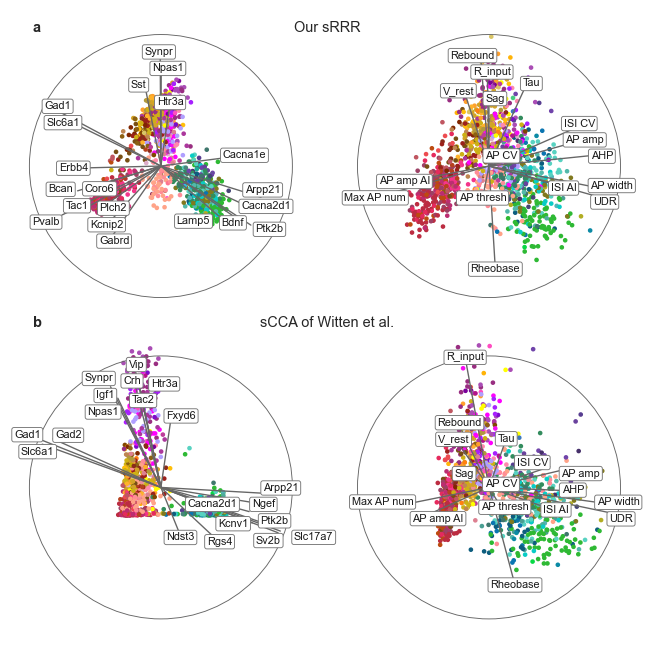

Correlation in X: 0.00
Correlation in Y: 0.03
Correlation in X: -0.33
Correlation in Y: -0.20


In [19]:
dataset = 2
sizes = [5, 5, 3, 3]
scaleFactor = 3.5
xylim = 3.9

fig = plt.figure(figsize=(5,5))

##############################################

Zx = X @ w
Zy = Y @ v
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)

print(f'Correlation in X: {np.corrcoef(Zx[:,0], Zx[:,1])[0,1]:.2f}')
print(f'Correlation in Y: {np.corrcoef(Zy[:,0], Zy[:,1])[0,1]:.2f}')

colors = [data['colors'][t] for t in data['ttype']]
    
plt.subplot(2,2,1, aspect='equal')
plt.scatter(Zx[:,0], Zx[:,1], s=sizes[dataset], color=colors)

plt.ylim([-xylim, xylim])
plt.xlim([-xylim, xylim])
plt.xticks([])
plt.yticks([])

labels = []
L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
for i in np.where((w[:,0]!=0)|(w[:,1]!=0))[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], genes[i], 
             ha='center', va='center', color='k', fontsize=6,
             bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
    labels.append(t)
adjustlabels(fig, labels)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
plt.gca().add_patch(circ)

plt.subplot(2,2,2, aspect='equal')
plt.scatter(Zy[:,0], Zy[:,1], s=sizes[dataset], color=colors)
    
plt.ylim([-xylim, xylim])
plt.xlim([-xylim, xylim])
plt.xticks([])
plt.yticks([])

labels = []
L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
                 zorder=1)
    t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], data['ephysNames'][i], 
                 ha='center', va='center', color='k', fontsize=6,
                 bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
    labels.append(t)
adjustlabels(fig, labels)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
plt.gca().add_patch(circ)

#################################################

w = w2
v = v2

##################

Zx = X @ w
Zy = Y @ v
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)

print(f'Correlation in X: {np.corrcoef(Zx[:,0], Zx[:,1])[0,1]:.2f}')
print(f'Correlation in Y: {np.corrcoef(Zy[:,0], Zy[:,1])[0,1]:.2f}')

colors = [data['colors'][t] for t in data['ttype']]
    
plt.subplot(2,2,3, aspect='equal')
plt.scatter(Zx[:,0], Zx[:,1], s=sizes[dataset], color=colors)

plt.ylim([-xylim, xylim])
plt.xlim([-xylim, xylim])
plt.xticks([])
plt.yticks([])

labels = []
L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
for i in np.where((w[:,0]!=0)|(w[:,1]!=0))[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], genes[i], 
             ha='center', va='center', color='k', fontsize=6,
             bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
    labels.append(t)
adjustlabels(fig, labels)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
plt.gca().add_patch(circ)

plt.subplot(2,2,4, aspect='equal')
plt.scatter(Zy[:,0], Zy[:,1], s=sizes[dataset], color=colors)
    
plt.ylim([-xylim, xylim])
plt.xlim([-xylim, xylim])
plt.xticks([])
plt.yticks([])

labels = []
L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
                 zorder=1)
    t = plt.text(scaleFactor*L[i,0], scaleFactor*L[i,1], data['ephysNames'][i], 
                 ha='center', va='center', color='k', fontsize=6,
                 bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
    labels.append(t)
adjustlabels(fig, labels)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
plt.gca().add_patch(circ)

##############################################3

sns.despine(left=True, bottom=True)
plt.tight_layout()

fig.text(.05, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.05, .5, 'b', fontsize=8, fontweight='bold')
fig.text(.5, .95, 'Our sRRR', fontsize=8, ha='center')
fig.text(.5, .5, 'sCCA of Witten et al.', fontsize=8, ha='center')

plt.savefig('figures/witten-biplot.png',dpi=200)
plt.savefig('figures/witten-biplot.pdf',dpi=200)

### Witten comparison to cca_zoo implementation

In [119]:
data = pickle.load(open('data/scala2020.pickle', 'rb'))
X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]

import spls_scca
w,v = witten(X, Y, lx=1000)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))
print('Ephys selected: {}'.format(np.sum(v[:,0]!=0)))

A = X.T @ Y
d = w.T @ A @ v
A = A - d * w @ v.T
w2, v2 = witten(A, lx = 1200)
print('Genes selected: {}'.format(np.sum(w2[:,0]!=0)))

w = np.concatenate((w,w2),axis=1)
v = np.concatenate((v,v2),axis=1)

Genes selected: 100
Ephys selected: 16
Genes selected: 0


In [26]:
# from cca_zoo.wrappers import PMD

# pmd = PMD(latent_dims=1, c=[1200, 0])
# pmd.fit(X, Y)

In [19]:
import rpy2
print(rpy2.__version__)

3.4.2


In [6]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')
# utils.install_packages('PMA')

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

from rpy2.robjects.packages import importr
pma = importr("PMA")
out = pma.CCA(X,Y,typex="standard",typez="standard",K=2,penaltyx=.19)

d = { key : out.rx2(key) for key in out.names }
u = np.asarray(d['u'])

np.sum(u[:,0]!=0)

12
123


62

In [93]:
np.corrcoef((X@u).T)

array([[1.        , 0.53398792],
       [0.53398792, 1.        ]])

In [98]:
# print(np.where(u[:,1]!=0))
# print(u[u[:,0]!=0,0])
# print(np.where(w[:,0]!=0))
# print(w[w[:,0]!=0,0])

# np.var(X,axis=0)

In [115]:
Y.T@X@w[:,0]

array([ 5588.64589964, -4227.1047533 ,   277.11361584,   580.6712342 ,
        7372.18704398,  6417.18248319,  4674.49897521,  4117.97542994,
       -1406.83867447, -6211.97062036,  1278.62150256, -1688.28602708,
       -2153.94297446,  1515.96670487,  -588.97109883,  7591.87161789])